In [51]:
%reset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate

from quantum_systems import ODQD, GeneralOrbitalSystem

In [15]:
#can be called only after creation of odho and before creation of system!!!
# plots the Atormic Orbital basis --> in our case the HO eigenstates
def plot_AO(odho): 
    plt.figure(figsize=(8, 5))
    plt.plot(odho.grid, potential(odho.grid))

    for i in range(odho.l):
        plt.plot( odho.grid, np.abs(odho.spf[i]) ** 2 + odho.h[i, i].real, label=r"$\chi_{" + f"{i}" + r"}$" )

    plt.grid()
    plt.legend()
    plt.show()

# prints the Molecular Orbitals obtained after the convergence of the HF method
# the basis has not been changed for the system
# it is used just for a comparison with the output of plot_MO_abc()
def plot_MO(system, epsilon, C):
    plt.figure(figsize=(12,8))
    plt.plot(system.grid, potential(system.grid))

    for i in range(system.l):
        to_plot = np.zeros( system.grid.shape, np.complex128 )
        for j in range(system.l):
            to_plot += system.spf[j] * C[j,i]
        plt.plot( system.grid,  np.abs(to_plot)**2 + epsilon[i], label=r"$\phi_{" + f"{i}" + r"}$" )

    plt.grid()
    plt.legend()
    plt.show()


# abc = after basis change, can be called only after system.change_basis(C)
# plots the Molecular Orbitals obtained after the convergence of the HF procedure
# here the basis of the system has already been changed
def plot_MO_abc(system, epsilon):
    plt.figure(figsize=(12, 8))
    plt.plot(system.grid, potential(system.grid))

    for i in range(system.l):
        plt.plot( system.grid, np.abs(system.spf[i]) ** 2 + epsilon[i], label=r"$\chi_{" + f"{i}" + r"}$" )

    plt.grid()
    plt.legend()
    plt.show()

def solve_HF(system, nparticles, tolerance, max_iter):
    i = 0
    epsilon, C = scipy.linalg.eigh(system.h)
    epsilon_old = epsilon
    density = evaluate_density_matrix(nparticles, C)
    deltaE=1

    while i<max_iter and deltaE>tolerance:
        f = np.zeros( system.h.shape, dtype=np.complex128 )
        density = evaluate_density_matrix(nparticles, C)

        for a in range(system.l):
            for b in range(system.l):
                f[a,b] = np.einsum('ij,ij', density, system.u[a,:,b,:], dtype=np.complex128)
        f += system.h
        
        epsilon, C = scipy.linalg.eigh(f)
        deltaE = sum(np.abs(epsilon - epsilon_old))/system.l
        epsilon_old = epsilon
        i+=1
    
    if(deltaE<tolerance): print("Converged")
    elif(i>=max_iter): print("Max iteration number reached")
    return epsilon, C
    

def evaluate_density_matrix(nparticles, coefficients):
    density = np.zeros( coefficients.shape, dtype=np.complex128)

    for i in range(nparticles):
        density += np.outer( coefficients[:,i], np.conjugate(coefficients[:,i]))
    
    return density

# contains two THEORETICALLY equivalent ways of evaluating the energy of the system
def total_energy(system, epsilon=None):
    energy = 0
    
    if epsilon is None:
        for i in range(2):
            energy += system.h[i,i]
            for j in range(2):
                energy += 0.5 * system.u[i,j,i,j]
    else:
        for i in range(2):
            for j in range(2):
                energy -= system.u[i,j,i,j] 
        energy = energy*0.5 + epsilon[0] + epsilon[1]

    return energy

In [16]:
### PARAMETERS ###
l = 10 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 101  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
omega = 0.25  # The frequency of the harmonic oscillator trap
potential=ODQD.HOPotential(omega)
nparticles = 2

In [17]:
odho = ODQD(l, grid_length, num_grid_points, a=a, alpha=alpha, potential=potential )
system = GeneralOrbitalSystem(n=nparticles, basis_set=odho, anti_symmetrize=True)
epsilon, C = solve_HF(system, nparticles=nparticles, tolerance=1e-4, max_iter=500)
#system.change_basis(C)

Converged


In [18]:
#total energy
print(total_energy(system, epsilon), system.compute_reference_energy())

(0.8397601439713785+0j) (1.384146939922355+0j)


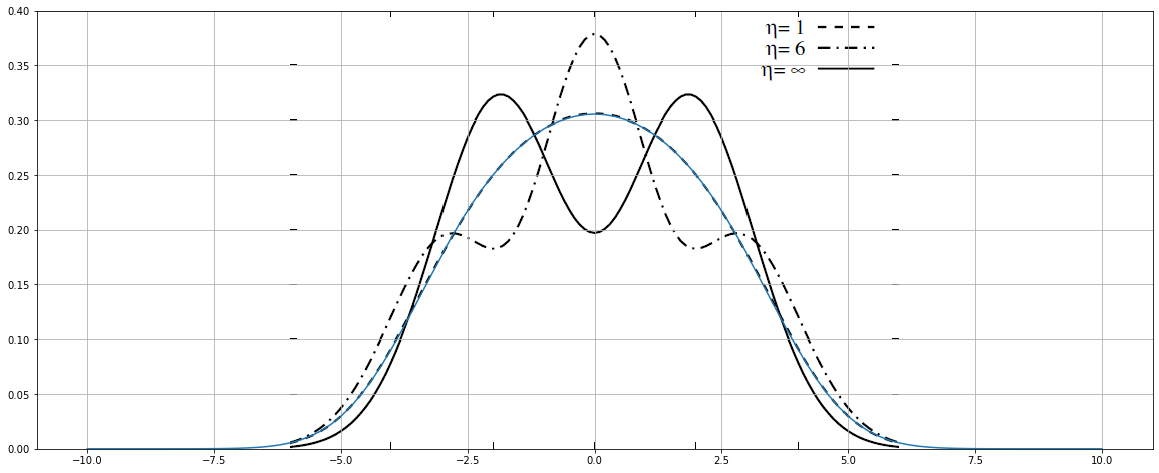

In [19]:
# particle density
density = evaluate_density_matrix(nparticles, C)

SD = system.compute_particle_density(density)
plt.figure(figsize=(20, 20))
img = plt.imread("theoretical_density.png")
ext = [-6.0, 6.0, 0.00, 0.4]
plt.imshow(img, zorder=0, extent=ext)
aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)
plt.plot(system.grid, SD.real)
plt.grid()
plt.show()